In [2]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None, 
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):
        
        color = next(color_cycle)
        
        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception('problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i+1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    

def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return
    
    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')
    
    
def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=True):    
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values
    
    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5
    
    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold
    
    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1 # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]
    
    saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind':      saccade_off_inds,
                    'saccade_end_timestamp':saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}
    
    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)
    
    distances = []
    angles = []
    speed_list = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) & 
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            speed_list.append(saccade_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                           endpoint['center_x'] - initial_position['center_x'])
        
        angles.append(overall_angle)  
        distances.append(distance_traveled)
        
        
    
    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(angles) % 360) # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df['initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df['initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)
        
    return df, saccade_events_df


In [3]:

# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict


# Example usage:
animals = ['PV_62','PV_126']
block_lists = [[23,24,26,38],[7,8,9,10,11,12,13]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks
)

instantiated block number 023 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_023, new OE version
Found the sample rate for block 023 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 023
got it!
instantiated block number 024 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_024, new OE version
Found the sample rate for block 024 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 024
got it!
instantiated block number 026 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_026, new OE version
Found the sample rate for block 026 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 026
got it!
instantiated block number 038 at Path: Z:\Nimrod\experi

In [4]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later
    
    # calibrate pupil diameter:
    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

running parse_open_ephys_events...
block 023 has a parsed events file, reading...
Getting eye brightness values for block 023...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 024 has a parsed events file, reading...
Getting eye brightness values for block 024...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 026 has a parsed events file, reading...
Getting eye brightness values for block 026...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_

In [5]:
def create_saccade_events_df_new(
    eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=True
):
    """
    Detects saccade events in eye tracking data, computes relevant metrics, and ensures data consistency.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.
    - bokeh_verify_threshold (bool): Whether to verify the speed threshold using Bokeh plots.
    - magnitude_calib (float): Calibration factor for speed and distance.
    - speed_profile (bool): Whether to compute and store speed profiles.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.
    """
    # Copy input DataFrame to avoid modifying it directly
    df = eye_data_df.copy()
    df["speed_x"] = df["center_x"].diff()  # Difference between consecutive 'center_x' values
    df["speed_y"] = df["center_y"].diff()  # Difference between consecutive 'center_y' values

    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df["speed_r"] = (df["speed_x"]**2 + df["speed_y"]**2)**0.5

    # Create a column for saccade detection
    df["is_saccade"] = df["speed_r"] > speed_threshold

    # Identify saccade onset and offset indices
    saccade_on_off = df["is_saccade"].astype(int) - df["is_saccade"].shift(periods=1, fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1  # Include frame before threshold crossing
    saccade_off_inds = np.where(saccade_on_off == -1)[0]

    # Handle cases where the last saccade has no end
    if len(saccade_on_inds) > len(saccade_off_inds):
        if len(saccade_on_inds) - len(saccade_off_inds) == 1:
            print("Detected unmatched final saccade start index. Truncating last saccade start index.")
            saccade_on_inds = saccade_on_inds[:-1]
        else:
            raise ValueError("Mismatch between saccade start and end indices. Manual inspection required.")

    # Extract timestamps and indices
    saccade_dict = {
        "saccade_start_ind": saccade_on_inds,
        "saccade_start_timestamp": df["OE_timestamp"].iloc[saccade_on_inds].values,
        "saccade_end_ind": saccade_off_inds,
        "saccade_end_timestamp": df["OE_timestamp"].iloc[saccade_off_inds].values,
        "saccade_on_ms": df["ms_axis"].iloc[saccade_on_inds].values,
        "saccade_off_ms": df["ms_axis"].iloc[saccade_off_inds].values,
    }

    # Ensure all lists have consistent lengths
    valid_mask = np.all(
        [
            len(saccade_dict[field]) == len(saccade_dict["saccade_start_ind"])
            for field in saccade_dict
        ]
    )
    if not valid_mask:
        valid_lengths = {key: len(value) for key, value in saccade_dict.items()}
        print(f"Detected inconsistent lengths in saccade fields: {valid_lengths}")
        raise ValueError("Fields in saccade dictionary must all have equal lengths.")

    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df["length"] = saccade_events_df["saccade_end_ind"] - saccade_events_df["saccade_start_ind"]

    # Compute saccade metrics
    distances = []
    angles = []
    speed_list = []
    speed_list_calib = []
    diameter_list = []

    for _, row in tqdm.tqdm(saccade_events_df.iterrows(), total=len(saccade_events_df)):
        saccade_samples = df.loc[
            (df["OE_timestamp"] >= row["saccade_start_timestamp"])
            & (df["OE_timestamp"] <= row["saccade_end_timestamp"])
        ]
        if saccade_samples.empty:
            continue

        # Distance traveled
        distance_traveled = saccade_samples["speed_r"].sum()
        distances.append(distance_traveled)

        # Speed profile
        if speed_profile:
            saccade_speed_profile = saccade_samples["speed_r"].values
            saccade_calib_speed_profile = saccade_speed_profile * magnitude_calib
            speed_list.append(saccade_speed_profile)
            speed_list_calib.append(saccade_calib_speed_profile)

        # Diameter profile
        saccade_diameter_profile = saccade_samples["pupil_diameter"].values
        diameter_list.append(saccade_diameter_profile)

        # Calculate angle
        initial_position = saccade_samples.iloc[0][["center_x", "center_y"]]
        endpoint = saccade_samples.iloc[-1][["center_x", "center_y"]]
        overall_angle = np.arctan2(
            endpoint["center_y"] - initial_position["center_y"],
            endpoint["center_x"] - initial_position["center_x"]
        )
        angles.append(overall_angle)

    # Add metrics to DataFrame
    saccade_events_df["magnitude_raw"] = np.array(distances)
    saccade_events_df["magnitude"] = np.array(distances) * magnitude_calib
    saccade_events_df["angle"] = np.rad2deg(angles) % 360  # Convert radians to degrees
    saccade_events_df["speed_profile"] = speed_list
    saccade_events_df["speed_profile_calib"] = speed_list_calib
    saccade_events_df["diameter_profile"] = diameter_list

    # Remove intermediate columns from df
    df = df.drop(["is_saccade"], axis=1)

    # Optional: Verify using Bokeh plot
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=["Pupil Velocity"], peaks=saccade_on_inds)

    return df, saccade_events_df

In [15]:
# saccade detection and annotation: 
for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_df(block.left_eye_data,
                                                               speed_threshold=4,
                                                               bokeh_verify_threshold=False,
                                                               magnitude_calib=block.L_pix_size)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_df(block.right_eye_data,
                                                               speed_threshold=4,
                                                               bokeh_verify_threshold=False,
                                                               magnitude_calib=block.R_pix_size)


78it [00:00, 760.22it/s]

PV_62, block 023, on 2023-04-27_10-52-42


602it [00:00, 724.91it/s]
599it [00:00, 776.55it/s]
79it [00:00, 784.78it/s]

PV_62, block 024, on 2023-04-27_11-22-56


602it [00:00, 739.26it/s]
599it [00:00, 756.92it/s]
77it [00:00, 766.54it/s]

PV_62, block 026, on 2023-04-27_12-21-41


598it [00:00, 753.49it/s]
579it [00:00, 755.47it/s]
71it [00:00, 707.46it/s]

PV_62, block 038, on 2023-05-01_13-57-45


1126it [00:01, 733.03it/s]
1123it [00:01, 734.09it/s]
78it [00:00, 776.04it/s]

PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12


1209it [00:01, 771.59it/s]
1180it [00:01, 772.18it/s]
75it [00:00, 742.97it/s]

PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41


366it [00:00, 732.00it/s]
399it [00:00, 730.79it/s]
74it [00:00, 727.40it/s]

PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15


359it [00:00, 749.73it/s]
434it [00:00, 755.26it/s]
71it [00:00, 704.81it/s]

PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57


245it [00:00, 724.06it/s]
288it [00:00, 764.38it/s]
160it [00:00, 791.80it/s]

PV_126, block 011, on PV126_Trial115_eyeTracking_w7


1009it [00:01, 781.43it/s]
1006it [00:01, 775.23it/s]
115it [00:00, 799.67it/s]
0it [00:00, ?it/s]

PV_126, block 012, on PV126_Trial116_eyeTracking_h8


129it [00:00, 768.02it/s]
84it [00:00, 815.92it/s]
0it [00:00, ?it/s]

PV_126, block 013, on PV126_Trial116_eyeTracking_h9


77it [00:00, 821.33it/s]


In [16]:
### over here, I get the lizard movements binary from mark's analysis
import os
def block_get_lizard_movement(block):
    # collect accelerometer data
    # path definition
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'path to mat file is {mat_path}')
    # read mat file
    try:
        mat_data = h5py.File(str(mat_path), 'r')
        mat_dict = {'t_mov_ms': mat_data['t_mov_ms'][:],
                    'movAll': mat_data['movAll'][:]}
        
        acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:, 0], mat_dict['movAll'][:, 0]]).T,
                              columns=['t_mov_ms', 'movAll'])
        mat_data.close()
        block.liz_mov_df = acc_df
        print(f'liz_mov_df created for {block}')
    except FileNotFoundError:
        print('mat file does not exist - run the matlab getLizMovement function')
        
    return

for block in block_collection:
    block_get_lizard_movement(block)

# this cell now labels the saccades as with/without head movements
def get_head_mov_col(df, mov_times):
    head_mov_bool = np.zeros(len(df), dtype=bool)  # Initialize array of False

    for i, saccade in enumerate(df.itertuples()):
        saccade_start = saccade.saccade_on_ms
        saccade_end = saccade.saccade_off_ms
        
        overlapping_mov_times = mov_times[np.logical_and(mov_times >= saccade_start, mov_times <= saccade_end)]
        
        if overlapping_mov_times.size > 0:  
            head_mov_bool[i] = True

    df['head_movement'] = head_mov_bool
    return df

def label_saccade_movements(block):
    mov_times = block.liz_mov_df.t_mov_ms.values
    block.l_saccade_df = get_head_mov_col(block.l_saccade_df,mov_times=mov_times)
    block.r_saccade_df = get_head_mov_col(block.r_saccade_df,mov_times=mov_times)

for block in block_collection:
    label_saccade_movements(block)


path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_023\oe_files\2023-04-27_10-52-42\Record Node 108\analysis\recNames=Block0023,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 023, on 2023-04-27_10-52-42
path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_024\oe_files\2023-04-27_11-22-56\Record Node 108\analysis\recNames=Block0024,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 024, on 2023-04-27_11-22-56
path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_026\oe_files\2023-04-27_12-21-41\Record Node 108\analysis\recNames=Block0026,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 026, on 2023-04-27_12-21-41
path to mat file is Z:\Nimrod\experiments\PV_62\2023_05_01\block_038\oe_files\2023-05-01_13-57-45\Record Node 108\analysis\recNames=Block0038,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 038, on 2023-05-01_13-57-45
path to mat file is Z:\Nimrod\experiments\PV_126\2024_07_18\block_007\oe_files\P

In [17]:
# add annotations for a joint dataframe:
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.r_saccade_df['animal'] = block.animal_call
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.l_saccade_df['animal'] = block.animal_call
    block.all_saccade_df = pd.concat([block.l_saccade_df,block.r_saccade_df])

In [18]:
saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)

In [19]:
def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val

def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm.tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples([(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))], names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers),len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df,r_non_synced_leftovers])
    
    return synced_df, non_synced_df

synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df.dropna()) + len(synced_df.dropna()) == len(saccade_df.dropna()):
        print('got them all')
        
    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


577it [00:00, 7297.98it/s]
577it [00:00, 4716.80it/s]


199 568


575it [00:00, 7508.25it/s]
0it [00:00, ?it/s]

199 568
190 547


1034it [00:00, 8401.72it/s]
1163it [00:00, 7051.06it/s]

599 1064



341it [00:00, 7327.78it/s]
338it [00:00, 7196.98it/s]

342 1110
181 386
204 414



230it [00:00, 7379.93it/s]
961it [00:00, 7245.17it/s]


129 273


107it [00:00, 6921.61it/s]
77it [00:00, 7005.21it/s]

366 988
50 123
19 75
got them all


In [20]:
def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples([(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)], names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df

synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)


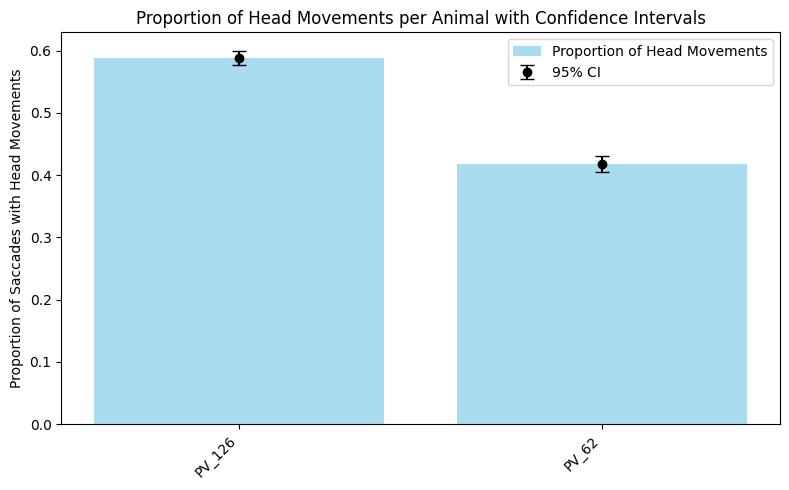

   animal  proportion    ci_low   ci_high  total_saccades
0  PV_126    0.587681  0.576021  0.599244            6900
1   PV_62    0.417811  0.405207  0.430523            5828


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint

def analyze_head_movement_proportions(saccade_collection, confidence_level=0.95, figure_size=(8, 5)):
    # Group data by animal
    results = []
    for animal, group in saccade_collection.groupby('animal'):
        total_saccades = len(group)
        head_movement_count = group['head_movement'].sum()

        # Calculate proportion and confidence intervals
        proportion = head_movement_count / total_saccades
        ci_low, ci_high = proportion_confint(
            count=head_movement_count,
            nobs=total_saccades,
            alpha=1-confidence_level,
            method='wilson'
        )

        results.append({
            'animal': animal,
            'proportion': proportion,
            'ci_low': ci_low,
            'ci_high': ci_high,
            'total_saccades': total_saccades
        })

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Plotting
    plt.figure(figsize=figure_size)
    animals = results_df['animal']
    proportions = results_df['proportion']
    ci_lows = results_df['ci_low']
    ci_highs = results_df['ci_high']

    # Bar plot with error bars
    plt.bar(animals, proportions, color='skyblue', alpha=0.7, label='Proportion of Head Movements')
    plt.errorbar(animals, proportions, 
                 yerr=[proportions - ci_lows, ci_highs - proportions],
                 fmt='o', color='black', capsize=5, label='95% CI')

    # Add labels and title
    plt.ylabel('Proportion of Saccades with Head Movements')
    plt.title('Proportion of Head Movements per Animal with Confidence Intervals')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()

    return results_df
# Call the function with your saccade_collection DataFrame
results_df = analyze_head_movement_proportions(saccade_collection)

# Display the results
print(results_df)

In [22]:
saccade_df.columns

Index(['saccade_start_ind', 'saccade_start_timestamp', 'saccade_end_ind',
       'saccade_end_timestamp', 'saccade_on_ms', 'saccade_off_ms', 'length',
       'magnitude_raw', 'magnitude', 'angle', 'initial_x', 'initial_y',
       'end_x', 'end_y', 'calib_dx', 'calib_dy', 'speed_profile',
       'diameter_profile', 'head_movement', 'eye', 'block', 'animal'],
      dtype='object')

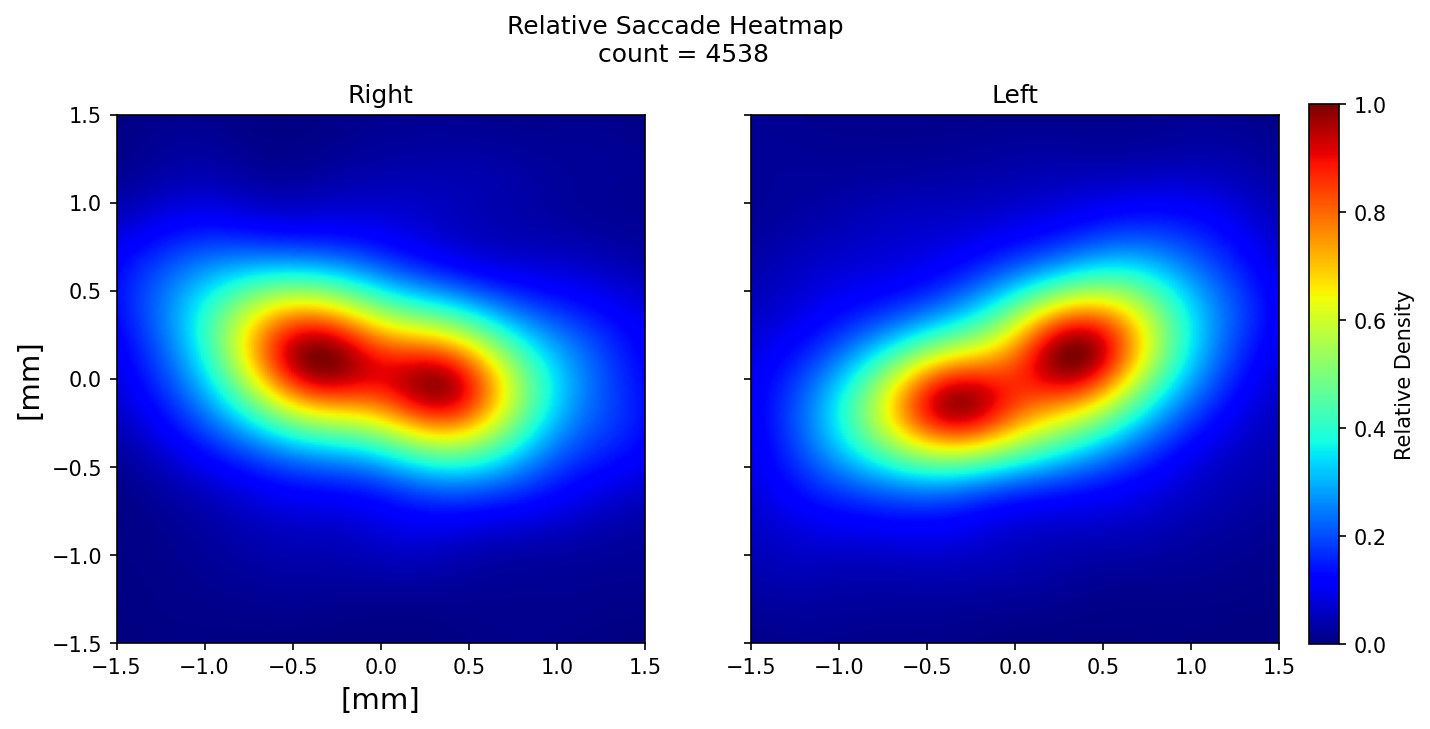

In [23]:
# Produce the all saccade heatmap

from matplotlib import colors, colorbar

saccade_df = synced_saccade_collection.query('animal == "PV_126"')
# parse queries:
l_dx = saccade_df.query('eye == "L"')['calib_dx'].dropna().values
r_dx = saccade_df.query('eye == "R"')['calib_dx'].dropna().values
l_dy = saccade_df.query('eye == "L"')['calib_dy'].dropna().values 
r_dy = saccade_df.query('eye == "R"')['calib_dy'].dropna().values
global_max=1.5
global_min=-1.5
fig, axes = plt.subplots(ncols=2, nrows=1, figsize =(10,6), dpi=150, sharey=True)
fig.suptitle(f'Relative Saccade Heatmap \n count = {len(l_dx) + len(r_dx)}', y=0.9)
sp1 = uf.plot_kde(axes[0],r_dx,r_dy,200,'Right',global_max=global_max,global_min=global_min)
sp2 = uf.plot_kde(axes[1],l_dx,l_dy,200,'Left',global_max=global_max,global_min=global_min)
axes[0].set_xlabel('[mm]',fontsize=14)
axes[0].set_ylabel('[mm]',fontsize=14)
# Add colorbar
cax = fig.add_axes([0.92, 0.20, 0.02, 0.6])  # [left, bottom, width, height]
cb = colorbar.ColorbarBase(cax, cmap=plt.cm.jet)
cb.set_label('Relative Density')

#plt.tight_layout()
# t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
# plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_heatmaps_all.pdf', format='pdf')
plt.show()

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os
import datetime
import pickle

def plot_saccade_heatmaps(saccade_collection, export_path=None, nbins=200, global_min=-1.5, global_max=1.5, cmap=plt.cm.jet):
    """
    Plots 2D KDE heatmaps for left and right eye saccades using imshow and optionally exports the plot and data.

    Parameters:
    - saccade_collection: DataFrame with saccade data
    - export_path: Path to export plot and data (optional)
    - nbins: Number of bins for KDE evaluation
    - global_min, global_max: Axis limits for KDE
    - cmap: Colormap for the heatmap
    """
    # Extract data
    l_dx = saccade_collection.query('eye == "L"')['calib_dx'].dropna().values
    r_dx = saccade_collection.query('eye == "R"')['calib_dx'].dropna().values
    l_dy = saccade_collection.query('eye == "L"')['calib_dy'].dropna().values
    r_dy = saccade_collection.query('eye == "R"')['calib_dy'].dropna().values

    # Create figure
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(3, 1.2), dpi=300, sharey=True)

    # Evaluate KDE
    def evaluate_kde(x, y, nbins, global_min, global_max):
        k = gaussian_kde(np.array([x, y]).astype(float))
        xi, yi = np.mgrid[global_min:global_max:nbins * 1j, global_min:global_max:nbins * 1j]
        zi = k(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)
        return zi, (global_min, global_max, global_min, global_max)

    # Plot KDE heatmaps using imshow
    zi_r, extent_r = evaluate_kde(r_dx, r_dy, nbins, global_min, global_max)
    sp1 = axes[0].imshow(zi_r.T, extent=extent_r, origin='lower', cmap=cmap)
    axes[0].set_title('Right')

    zi_l, extent_l = evaluate_kde(l_dx, l_dy, nbins, global_min, global_max)
    sp2 = axes[1].imshow(zi_l.T, extent=extent_l, origin='lower', cmap=cmap)
    axes[1].set_title('Left')

    # Customize appearance
    for ax in axes:
        ax.set_xlabel('[mm]', fontsize=10)
        ax.set_ylabel('[mm]', fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_aspect('equal', 'box')

    # Add colorbar
    cax = fig.add_axes([0.92, 0.20, 0.02, 0.6])
    cb = plt.colorbar(sp1, cax=cax)
    cb.set_label('Relative Density', fontsize=10)

    # Final adjustments
    #fig.suptitle(f'Relative Saccade Heatmap\nCount = {len(l_dx) + len(r_dx)}', y=0.95, fontsize=11)
    

    # Handle export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_heatmaps_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        # Save plot
        pdf_file = os.path.join(full_export_path, "saccade_heatmaps_non_synced.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)

        # Save data
        data_file = os.path.join(full_export_path, "saccade_collections.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(saccade_collection, f)

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


def load_and_plot_saccade_data(load_path, nbins=200, global_min=-1.5, global_max=1.5, cmap=plt.cm.jet):
    """
    Loads saccade data from a pickle file and re-plots the heatmaps.

    Parameters:
    - load_path: Path to the pickle file
    - nbins: Number of bins for KDE evaluation
    - global_min, global_max: Axis limits for KDE
    - cmap: Colormap for the heatmap
    """
    data_file = os.path.join(load_path, "saccade_collections.pkl")

    try:
        with open(data_file, 'rb') as f:
            saccade_collection = pickle.load(f)
    except FileNotFoundError:
        print(f"Data file not found at {data_file}")
        return

    # Re-plot
    plot_saccade_heatmaps(saccade_collection, export_path=None, nbins=nbins, global_min=global_min, global_max=global_max, cmap=cmap)


Exported plot and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\relative_saccade_heatmaps_PV_126\saccade_heatmaps_2025_02_13_11_45_40


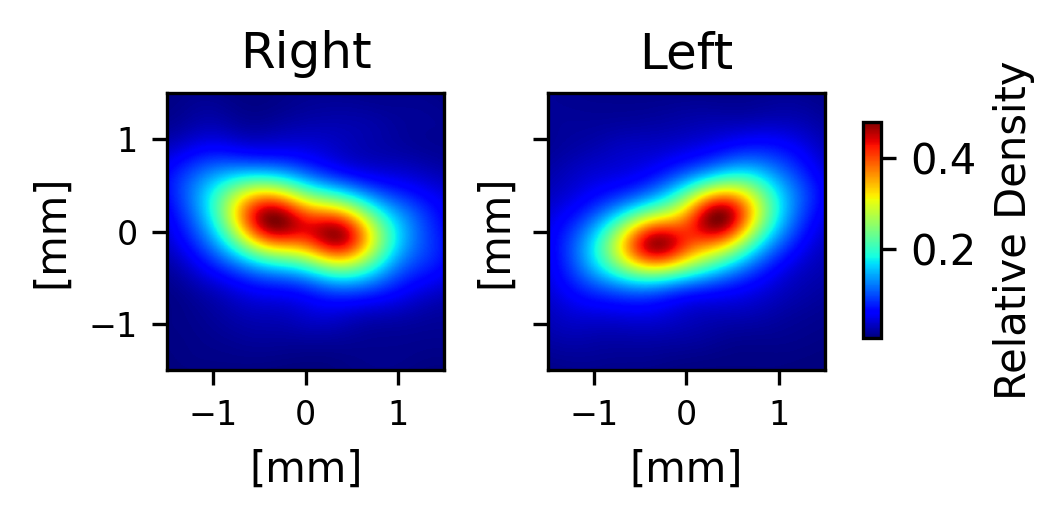

In [32]:
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\relative_saccade_heatmaps_PV_126')
plot_saccade_heatmaps(saccade_collection=synced_saccade_collection.query('animal == "PV_126"'),export_path=export_path)

Exported plot and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\relative_saccade_heatmaps_PV_126\saccade_heatmaps_2025_02_13_11_45_52


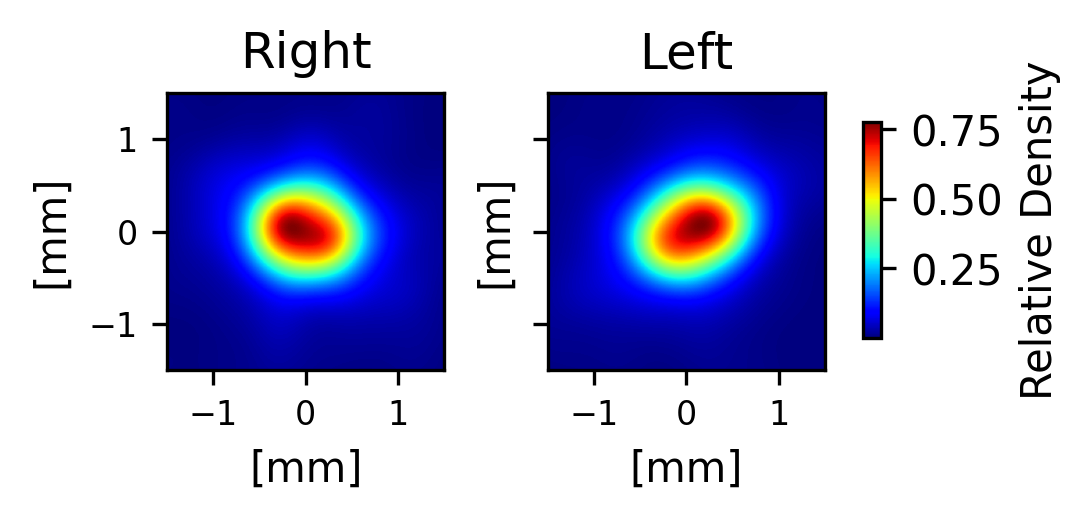

In [33]:
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\relative_saccade_heatmaps_PV_126')
plot_saccade_heatmaps(saccade_collection=non_synced_saccade_collection.query('animal == "PV_126"'),export_path=export_path)

Exported plot and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\saccade_heatmaps_2025_02_13_12_09_16


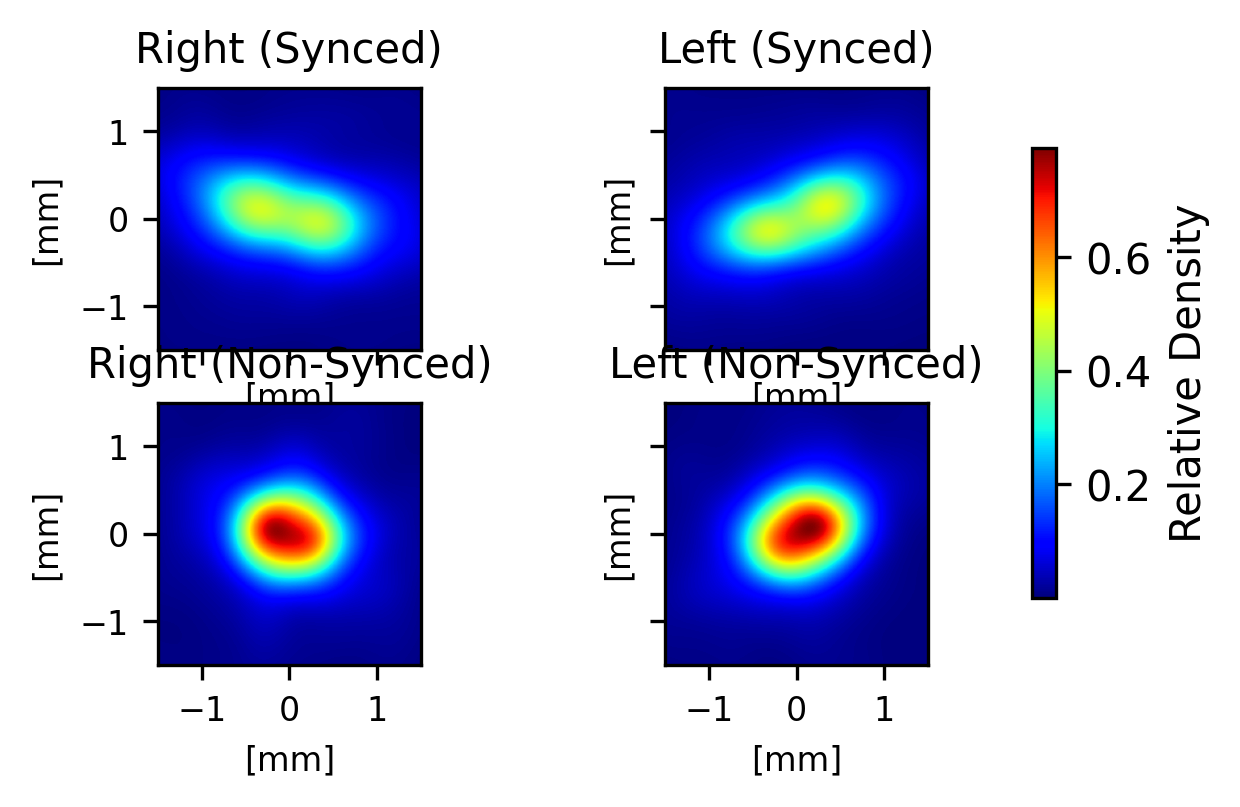

In [37]:
### Attempt to make a joint graph for both conditions
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os
import datetime
import pickle

def plot_saccade_heatmaps_comparison(synced_saccades, non_synced_saccades, export_path=None, nbins=200,
                                     global_min=-1.5, global_max=1.5, cmap=plt.cm.turbo, figsize=(4, 2.5)):
    """
    Plots a stacked 2D KDE heatmap for synced (top) and non-synced (bottom) saccades,
    ensuring a consistent colorbar scale across both conditions.
    
    Parameters:
    - synced_saccades: DataFrame with saccade data for the synced condition
    - non_synced_saccades: DataFrame with saccade data for the non-synced condition
    - export_path: Path to export the plot and data (optional)
    - nbins: Number of bins for KDE evaluation
    - global_min, global_max: Axis limits for KDE
    - cmap: Colormap for the heatmap
    - figsize: Tuple specifying the figure size
    """
    # Extract data
    def extract_eye_data(df, eye):
        return df.query('eye == @eye')[['calib_dx', 'calib_dy']].dropna().values.T
    
    l_dx_s, l_dy_s = extract_eye_data(synced_saccades, "L")
    r_dx_s, r_dy_s = extract_eye_data(synced_saccades, "R")
    l_dx_ns, l_dy_ns = extract_eye_data(non_synced_saccades, "L")
    r_dx_ns, r_dy_ns = extract_eye_data(non_synced_saccades, "R")
    
    # Function to evaluate KDE
    def evaluate_kde(x, y):
        k = gaussian_kde(np.array([x, y]).astype(float))
        xi, yi = np.mgrid[global_min:global_max:nbins * 1j, global_min:global_max:nbins * 1j]
        zi = k(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)
        return zi
    
    # Compute KDEs
    zi_r_s, zi_l_s = evaluate_kde(r_dx_s, r_dy_s), evaluate_kde(l_dx_s, l_dy_s)
    zi_r_ns, zi_l_ns = evaluate_kde(r_dx_ns, r_dy_ns), evaluate_kde(l_dx_ns, l_dy_ns)
    
    # Determine a consistent color scale
    vmin, vmax = min(zi_r_s.min(), zi_l_s.min(), zi_r_ns.min(), zi_l_ns.min()), max(zi_r_s.max(), zi_l_s.max(), zi_r_ns.max(), zi_l_ns.max())
    
    # Create figure
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=figsize, dpi=300, sharey=True, sharex=True)
    
    # Plot heatmaps
    def plot_heatmap(ax, zi, title):
        im = ax.imshow(zi.T, extent=[global_min, global_max, global_min, global_max], origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('[mm]', fontsize=8)
        ax.set_ylabel('[mm]', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_aspect('equal', 'box')
        return im
    
    im1 = plot_heatmap(axes[0, 0], zi_r_s, 'Right (Synced)')
    im2 = plot_heatmap(axes[0, 1], zi_l_s, 'Left (Synced)')
    im3 = plot_heatmap(axes[1, 0], zi_r_ns, 'Right (Non-Synced)')
    im4 = plot_heatmap(axes[1, 1], zi_l_ns, 'Left (Non-Synced)')
    
    # Add colorbar
    cax = fig.add_axes([0.92, 0.20, 0.02, 0.6])
    cb = plt.colorbar(im1, cax=cax)
    cb.set_label('Relative Density', fontsize=10)
    
    #plt.tight_layout(rect=[0, 0, 0.9, 1])
    
    # Handle export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_heatmaps_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        
        # Save plot
        pdf_file = os.path.join(full_export_path, "saccade_heatmaps_comparison.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        
        # Save data
        data_file = os.path.join(full_export_path, "saccade_collections.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({'synced': synced_saccades, 'non_synced': non_synced_saccades}, f)
        
        print(f"Exported plot and data to: {full_export_path}")
    
    plt.show()

export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material')
synced_saccades = synced_saccade_collection.query('animal == "PV_126"')
non_synced_saccades = non_synced_saccade_collection.query('animal == "PV_126"')
plot_saccade_heatmaps_comparison(synced_saccades, non_synced_saccades, export_path=export_path, 
                                 nbins=200,global_min=-1.5, global_max=1.5, cmap=plt.cm.jet, 
                                 figsize=(4, 2.5))

<ipython-input-41-bb03eaf0402c>:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


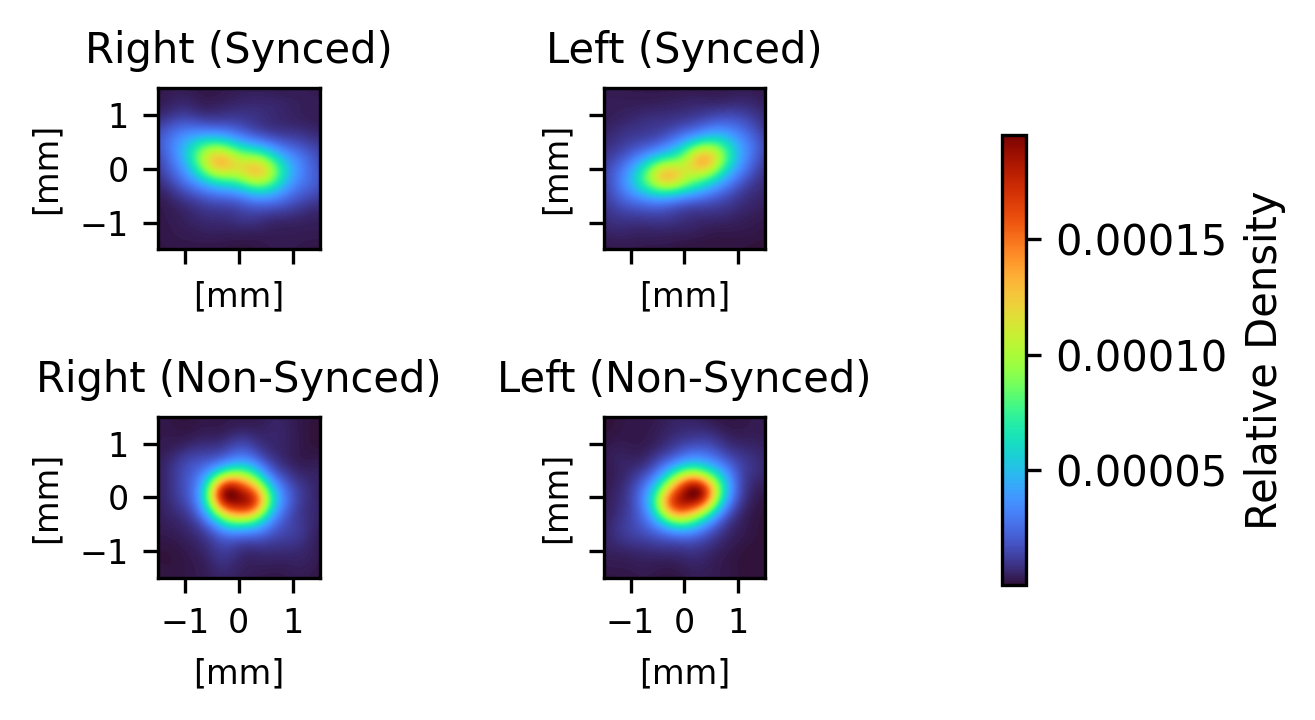

In [41]:
# This is a version with a normalized result (total should be =1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os
import datetime
import pickle

def plot_saccade_heatmaps_comparison(synced_saccades, non_synced_saccades, export_path=None, nbins=200,
                                     global_min=-1.5, global_max=1.5, cmap=plt.cm.turbo, figsize=(4, 2.5)):
    """
    Plots a stacked 2D KDE heatmap for synced (top) and non-synced (bottom) saccades,
    ensuring a consistent colorbar scale across both conditions with integral normalization.
    
    Parameters:
    - synced_saccades: DataFrame with saccade data for the synced condition
    - non_synced_saccades: DataFrame with saccade data for the non-synced condition
    - export_path: Path to export the plot and data (optional)
    - nbins: Number of bins for KDE evaluation
    - global_min, global_max: Axis limits for KDE
    - cmap: Colormap for the heatmap
    - figsize: Tuple specifying the figure size
    """
    # Extract data
    def extract_eye_data(df, eye):
        return df.query('eye == @eye')[['calib_dx', 'calib_dy']].dropna().values.T
    
    l_dx_s, l_dy_s = extract_eye_data(synced_saccades, "L")
    r_dx_s, r_dy_s = extract_eye_data(synced_saccades, "R")
    l_dx_ns, l_dy_ns = extract_eye_data(non_synced_saccades, "L")
    r_dx_ns, r_dy_ns = extract_eye_data(non_synced_saccades, "R")
    
    # Function to evaluate KDE with integral normalization
    def evaluate_kde(x, y):
        k = gaussian_kde(np.array([x, y]).astype(float))
        xi, yi = np.mgrid[global_min:global_max:nbins * 1j, global_min:global_max:nbins * 1j]
        zi = k(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)
        
        # Normalize so the sum over the plotting area equals 1
        zi /= np.sum(zi)
        return zi
    
    # Compute KDEs
    zi_r_s, zi_l_s = evaluate_kde(r_dx_s, r_dy_s), evaluate_kde(l_dx_s, l_dy_s)
    zi_r_ns, zi_l_ns = evaluate_kde(r_dx_ns, r_dy_ns), evaluate_kde(l_dx_ns, l_dy_ns)
    
    # Determine a consistent color scale
    vmin, vmax = min(zi_r_s.min(), zi_l_s.min(), zi_r_ns.min(), zi_l_ns.min()), max(zi_r_s.max(), zi_l_s.max(), zi_r_ns.max(), zi_l_ns.max())
    
    # Create figure
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=figsize, dpi=300, sharey=True, sharex=True)
    
    # Plot heatmaps
    def plot_heatmap(ax, zi, title):
        im = ax.imshow(zi.T, extent=[global_min, global_max, global_min, global_max], origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('[mm]', fontsize=8)
        ax.set_ylabel('[mm]', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_aspect('equal', 'box')
        return im
    
    im1 = plot_heatmap(axes[0, 0], zi_r_s, 'Right (Synced)')
    im2 = plot_heatmap(axes[0, 1], zi_l_s, 'Left (Synced)')
    im3 = plot_heatmap(axes[1, 0], zi_r_ns, 'Right (Non-Synced)')
    im4 = plot_heatmap(axes[1, 1], zi_l_ns, 'Left (Non-Synced)')
    
    # Add colorbar
    cax = fig.add_axes([0.92, 0.20, 0.02, 0.6])
    cb = plt.colorbar(im1, cax=cax)
    cb.set_label('Relative Density', fontsize=10)
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    
    # Handle export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_heatmaps_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        
        # Save plot
        pdf_file = os.path.join(full_export_path, "saccade_heatmaps_comparison.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        
        # Save data
        data_file = os.path.join(full_export_path, "saccade_collections.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({'synced': synced_saccades, 'non_synced': non_synced_saccades}, f)
        
        print(f"Exported plot and data to: {full_export_path}")
    
    plt.show()
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material')
synced_saccades = synced_saccade_collection.query('animal == "PV_126"')
non_synced_saccades = non_synced_saccade_collection.query('animal == "PV_126"')
plot_saccade_heatmaps_comparison(synced_saccades, non_synced_saccades, export_path=None, 
                                 nbins=200,global_min=-1.5, global_max=1.5, cmap=plt.cm.turbo, 
                                 figsize=(4, 2.5))

In [35]:
import numpy as np

def calculate_orientation_tuning(saccade_angles):
    """
    Calculates the orientation tuning statistic for a collection of saccade angles.

    Parameters:
        saccade_angles (array-like): List or array of saccade angles in degrees.

    Returns:
        float: Orientation tuning statistic.
    """
    # Convert angles to range [0, 360] if they aren't already
    saccade_angles = np.array(saccade_angles) % 360
    
    # Define horizontal saccade ranges
    horizontal_ranges = [
        (315, 360),  # 330° to 0°
        (0, 45),     # 0° to 30°
        (135, 225)   # 150° to 210°
    ]
    
    # Identify horizontal saccades
    is_horizontal = np.logical_or.reduce([
        (saccade_angles >= low) & (saccade_angles <= high)
        if low < high else
        (saccade_angles >= low) | (saccade_angles <= high)
        for low, high in horizontal_ranges
    ])
    
    # Calculate probabilities
    p_horizontal = np.sum(is_horizontal) / len(saccade_angles)
    p_vertical = 1 - p_horizontal  # Vertical saccades are the complement
    
    # Calculate orientation tuning
    tuning_statistic = (p_horizontal - p_vertical) / (p_horizontal + p_vertical)
    
    return tuning_statistic

calculate_orientation_tuning(synced_saccade_collection.angle)


0.4639255236617532

In [37]:
calculate_orientation_tuning(non_synced_saccade_collection.angle)

0.22195600087126977

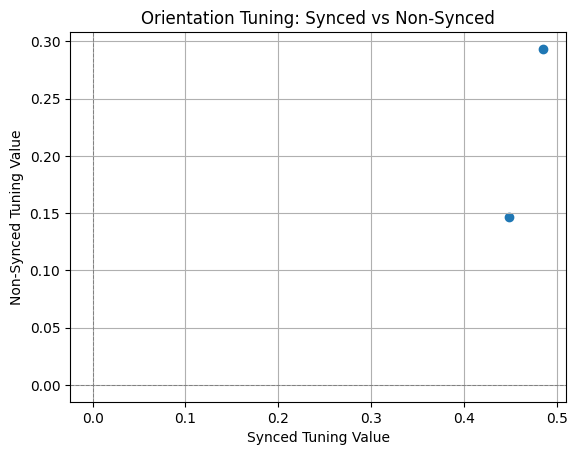

{'PV_62': (0.4856070087609512, 0.2933673469387754),
 'PV_126': (0.44865579550462753, 0.1469405984814649)}

In [45]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_orientation_tuning(synced_df, non_synced_df):
    """
    Analyze orientation tuning for each unique animal in the given dataframes.

    Parameters:
        synced_df (pd.DataFrame): DataFrame containing 'animal' and 'angle' columns for synchronized saccades.
        non_synced_df (pd.DataFrame): DataFrame containing 'animal' and 'angle' columns for non-synchronized saccades.

    Returns:
        dict: Dictionary with animal IDs as keys and a tuple of (synced_tuning, non_synced_tuning) as values.
    """
    # Initialize dictionary to store results
    tuning_results = {}

    # Get unique animals
    unique_animals = synced_df['animal'].unique()

    for animal in unique_animals:
        # Filter data for the current animal
        synced_angles = synced_df.query('animal == @animal')['angle'].values
        non_synced_angles = non_synced_df.query('animal == @animal')['angle'].values

        # Calculate orientation tuning
        synced_tuning = calculate_orientation_tuning(synced_angles)
        non_synced_tuning = calculate_orientation_tuning(non_synced_angles)

        # Save to dictionary
        tuning_results[animal] = (synced_tuning, non_synced_tuning)

    # Plot results
    fig, ax = plt.subplots()
    synced_tuning_values = [v[0] for v in tuning_results.values()]
    non_synced_tuning_values = [v[1] for v in tuning_results.values()]
    ax.scatter(synced_tuning_values, non_synced_tuning_values)

    # Add labels and title
    ax.set_xlabel("Synced Tuning Value")
    ax.set_ylabel("Non-Synced Tuning Value")
    ax.set_title("Orientation Tuning: Synced vs Non-Synced")
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.7)
    plt.grid(True)
    plt.show()

    return tuning_results
analyze_orientation_tuning(synced_saccade_collection,non_synced_saccade_collection)

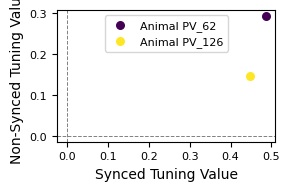

{'PV_62': (0.4856070087609512, 0.2933673469387754),
 'PV_126': (0.44865579550462753, 0.1469405984814649)}

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_orientation_tuning(synced_df, non_synced_df):
    """
    Analyze orientation tuning for each unique animal in the given dataframes.

    Parameters:
        synced_df (pd.DataFrame): DataFrame containing 'animal' and 'angle' columns for synchronized saccades.
        non_synced_df (pd.DataFrame): DataFrame containing 'animal' and 'angle' columns for non-synchronized saccades.

    Returns:
        dict: Dictionary with animal IDs as keys and a tuple of (synced_tuning, non_synced_tuning) as values.
    """
    # Initialize dictionary to store results
    tuning_results = {}

    # Get unique animals
    unique_animals = synced_df['animal'].unique()

    for animal in unique_animals:
        # Filter data for the current animal
        synced_angles = synced_df.query('animal == @animal')['angle'].values
        non_synced_angles = non_synced_df.query('animal == @animal')['angle'].values

        # Calculate orientation tuning
        synced_tuning = calculate_orientation_tuning(synced_angles)
        non_synced_tuning = calculate_orientation_tuning(non_synced_angles)

        # Save to dictionary
        tuning_results[animal] = (synced_tuning, non_synced_tuning)

    # Plot results
    fig, ax = plt.subplots(figsize=(3, 2))

    synced_tuning_values = [v[0] for v in tuning_results.values()]
    non_synced_tuning_values = [v[1] for v in tuning_results.values()]
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_animals)))  # Generate unique colors

    for i, animal in enumerate(unique_animals):
        ax.scatter(
            synced_tuning_values[i],
            non_synced_tuning_values[i],
            color=colors[i],
            label=f"Animal {animal}",
            s=30  # Marker size
        )

    # Formatting
    ax.set_xlabel("Synced Tuning Value", fontsize=10)
    ax.set_ylabel("Non-Synced Tuning Value", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_aspect('equal', adjustable='box')  # Equal axes
    ax.legend(fontsize=8, loc='best')
    ax.grid(False)
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.7)

    plt.tight_layout()
    plt.show()

    return tuning_results
analyze_orientation_tuning(synced_saccade_collection,non_synced_saccade_collection)